In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import torch
from torch import nn
import matplotlib.pyplot as plt
import sphericart.torch as sct
import numpy as np

### Implement Bessel radial basis layer

In [2]:
class SphericalBessel(nn.Module):
    def __init__(self, k_max: int = 1, l_max: int = 0):
        super().__init__()
        self.k_max = k_max
        self.l_max = l_max

    def forward(self, r):
        k = torch.linspace(1, self.k_max, self.k_max)
        r = r.to(torch.float64)[:,None]*k[None,:]
        y = torch.zeros([self.l_max]+[s for s in r.shape], dtype=torch.float64)

        lstart = self.l_max + int(torch.sqrt(torch.Tensor([10*self.l_max])))
        j2 = torch.zeros_like(r, dtype=torch.float64)
        j1 = torch.ones_like(r, dtype=torch.float64)

        for i in range(lstart, 0, -1):
            j0 = (2*i+1)/r * j1 - j2
            if i-1<self.l_max:
                y[i-1,...] = j0
            j2 = j1
            j1 = j0


        true_j0 = torch.sinc(r/torch.pi)
        y = y * true_j0/y[0,...]
        y = y.transpose(0,1)*torch.sqrt(torch.Tensor([2])/torch.pi)*k[None, None,:]
        return y.to(torch.float32)

torch.Size([120, 80, 20])

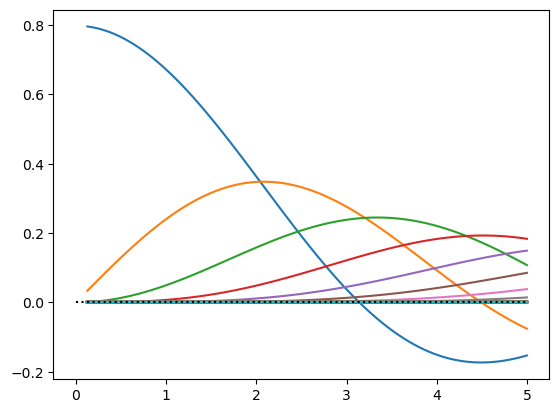

In [3]:
r = torch.linspace(0,5,120)
bessel = SphericalBessel(k_max=20, l_max=80)
y = bessel(r)
plt.plot(r, y[:,:,0])
plt.plot([0,torch.max(r)],[0,0], ':k')
y.shape

### Implement fourier series for time

In [4]:
t = torch.linspace(0,1,200)

In [5]:
class FourierSeries(nn.Module):
    def __init__(self, n_max: int = 1, scale = 1):
        super().__init__()
        self.n_max = n_max
        self.scale = scale

    def forward(self, t):
        n = torch.linspace(1, self.n_max, self.n_max)
        t = t.to(torch.float64)[:,None]
        
        return torch.cat((t*0+1, torch.sin(t*n[None,:]*2*torch.pi/self.scale), torch.cos(t*n[None,:]*2*torch.pi/self.scale)), dim=-1).to(torch.float32)

torch.Size([200, 11])

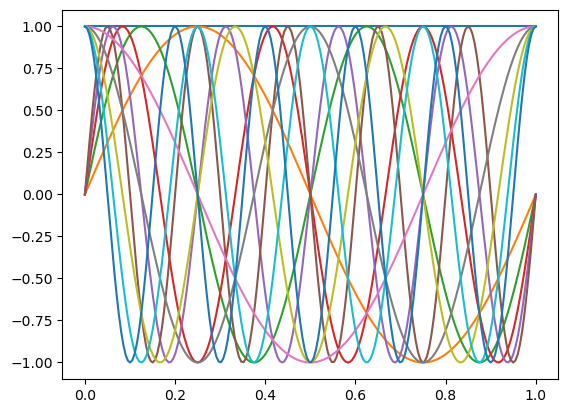

In [6]:
fourier = FourierSeries(n_max=5, scale=1)
y = fourier(t)
plt.plot(t, y)
y.shape

### Implement spherical harmonics for theta and phi

In [7]:
class SphericalHarmonicsModule(nn.Module):
    def __init__(self, l_max: int = 1):
        super().__init__()
        self.l_max = l_max
        self.sh = sct.SphericalHarmonics(l_max=self.l_max, normalized=True)

    def forward(self, xyz):
        sh_values = self.sh.compute(xyz)
        y = torch.zeros(sh_values.shape[0], self.l_max+1, 2*self.l_max+1)

        n = 0
        for l in np.arange(0, self.l_max+1):
            for m in np.arange(-l, l+1):
                y[:, l, m+self.l_max] = sh_values[:,n]
                n = n+1
        
        return y
       

In [8]:
theta = torch.linspace(1*torch.pi/180, torch.pi-1*torch.pi/180, 130)
phi = torch.linspace(0, 2*torch.pi, 260)

x = torch.sin(theta[:,None])*torch.cos(phi[None,:])
y = torch.sin(theta[:,None])*torch.sin(phi[None,:])
z = torch.cos(theta[:,None]).expand(x.shape)

xyz = torch.stack((x.reshape(-1), y.reshape(-1), z.reshape(-1)), dim=-1)

torch.Size([33800, 10, 19])
torch.Size([130, 260, 10, 19])


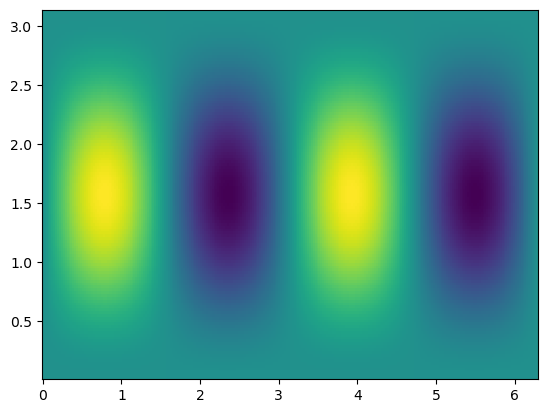

In [17]:
l_max = 9
spherical_harmonics = SphericalHarmonicsModule(l_max=l_max)
out = spherical_harmonics(xyz)
print(out.shape)

out = out.reshape([s for s in x.shape]+[out.shape[1], out.shape[2]])
print(out.shape)
plt.pcolormesh(phi, theta, out[:,:,2, l_max-2])

### Implement orthonormal time spherical NeRF

In [42]:
class SplineLinear(nn.Linear):
    def __init__(self, in_features: int, out_features: int, init_scale: float = 0.1, **kw) -> None:
        self.init_scale = init_scale
        super().__init__(in_features, out_features, bias=False, **kw)

    def reset_parameters(self) -> None:
        nn.init.trunc_normal_(self.weight, mean=0, std=self.init_scale)

In [43]:
class OrthonormalTimeSphericalNeRF(nn.Module):
    def __init__(self,
                output_dim: int = 2,
                k_max: int = 1, 
                l_max: int = 1, 
                n_max: int = 1,
                t_scale: float = 1.,
                spline_weight_init_scale: float = 0.1, 
                base_log_temperature: float = 5.0,
                base_log_density: float = 10.0):
        
        super().__init__()

        self.base_log_temperature = base_log_temperature
        self.base_log_density = base_log_density

        self.k_max = k_max
        self.l_max = l_max
        self.n_max = n_max
        self.t_scale = t_scale

        self.r_bessel = SphericalBessel(k_max=k_max, l_max=l_max+1)
        self.sh = SphericalHarmonicsModule(l_max=l_max)
        self.t_fourier = FourierSeries(n_max=n_max, scale=t_scale)

        self.spline_linear = SplineLinear((2*n_max+1)*k_max*(l_max+1)*(2*l_max+1), output_dim, spline_weight_init_scale)

        print((2*n_max+1)*k_max*(l_max+1)*(2*l_max+1))

        # Absorption for AIA, referred to instrument 0, EUVI-A refers to instrument 1, EUVI-B refers to instrument 2
        self.log_absortpion = nn.ParameterDict([
                                ['094',  torch.tensor(10.0, dtype=torch.float32)],
                                ['0131', torch.tensor(15.0, dtype=torch.float32)],
                                ['0171', torch.tensor(15.0, dtype=torch.float32)],
                                ['0193', torch.tensor(15.0, dtype=torch.float32)],
                                ['0211', torch.tensor(15.0, dtype=torch.float32)],
                                ['0304', torch.tensor(15.0, dtype=torch.float32)],
                                ['0335', torch.tensor(15.0, dtype=torch.float32)],
                                ['1171', torch.tensor(15.0, dtype=torch.float32)],
                                ['1195', torch.tensor(15.0, dtype=torch.float32)],
                                ['1284', torch.tensor(15.0, dtype=torch.float32)],
                                ['1304', torch.tensor(15.0, dtype=torch.float32)],
                                ['2171', torch.tensor(15.0, dtype=torch.float32)],
                                ['2195', torch.tensor(15.0, dtype=torch.float32)],
                                ['2284', torch.tensor(15.0, dtype=torch.float32)],
                                ['2304', torch.tensor(15.0, dtype=torch.float32)],
                        ])        

        self.volumetric_constant = nn.ParameterDict([
                                ['0', torch.tensor(1.0, dtype=torch.float32)],
                                ['1', torch.tensor(1.0, dtype=torch.float32)],
                                ['2', torch.tensor(1.0, dtype=torch.float32)],
                        ])

    def forward(self, x):
        fourier = self.t_fourier(x[:, 3])
        bessel = self.r_bessel(torch.sqrt(x[:, 0]*x[:, 0] + x[:, 1]*x[:, 1] + x[:, 2]*x[:, 2]))
        sh = self.sh(x[:, 0:3].contiguous())

        x = self.spline_linear((sh[:,:,:,None, None]*bessel[:,:,None,:, None]*fourier[:, None, None, None,:]).reshape(x.shape[0], -1))
        
        # Add base density
        x[:, 0] = x[:, 0] + self.base_log_density
        # Add base temperature
        x[:, 1] = x[:, 1] + self.base_log_temperature

        return {'inferences': x, 'log_abs': self.log_absortpion , 'vol_c': self.volumetric_constant}

In [44]:
model = OrthonormalTimeSphericalNeRF(k_max = 20, l_max = 20, n_max = 20)

706020


In [45]:
xyzt = torch.rand([22, 4])
xyzt.shape

torch.Size([22, 4])

In [46]:
model(xyzt)

{'inferences': tensor([[12.0187,  5.9962],
         [ 6.4641,  4.7581],
         [11.3607, 16.5080],
         [ 7.1407, 12.2569],
         [ 3.3661,  2.5559],
         [11.2376,  3.7625],
         [ 8.6844,  2.1685],
         [16.2340,  9.1980],
         [ 4.7001,  5.0519],
         [13.8077,  4.0776],
         [ 0.1598,  4.9007],
         [ 3.6238,  6.9572],
         [17.8522,  6.2085],
         [ 3.7634,  3.2808],
         [10.6834, 14.1237],
         [ 3.1636, 12.5967],
         [ 7.9925,  7.5868],
         [ 5.7916,  2.2147],
         [ 6.8310,  0.2619],
         [10.7571, 11.9273],
         [ 7.1373,  4.0809],
         [ 8.2162,  4.1981]], grad_fn=<CopySlices>),
 'log_abs': ParameterDict(
     (094): Parameter containing: [torch.FloatTensor of size ]
     (0131): Parameter containing: [torch.FloatTensor of size ]
     (0171): Parameter containing: [torch.FloatTensor of size ]
     (0193): Parameter containing: [torch.FloatTensor of size ]
     (0211): Parameter containing: [torch.